# Swap with Counterparty Risk (CVA)

The goal of the project is to compute the market value of a swap where the counterparty  might default. The input parameters are:

* The par rate of a set of Overnight Index Swaps (i.e. their market quotation)
* A set of forward libor rates and their fixing dates
* A set of survival probabilities for the risky counterparty
* The static data of the swap (nominal, maturity, underlying libor tenor, etc..). The fixed rate of the swap is such that if there was no counterparty risk, the product would be traded at par. You are requested to compute it.
* The recovery rate for this swap (i.e. the fraction of the market value that it is expected to recover in case of default).
* The volatility of the swap rate, which is assumed to be constant through time (the swap rate is lognormal with fixed volatility)

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for CVA estimation


Credit Valuation Adjustment risk is the potential source of loss due to changes in counterparty credit spreads and other market risk factors: bank that undertake derivative or securities financing transactions are subject to the risk of incurring mark-to -market losses because of the deterioration in the creditworthiness of their counterparties. CVA is complementary to the risk of a counterparty defaulting, which is known as counterparty credit risk. While Credit VaR measures the risk of losses faced due to the possible default of some counterparty, CVA measures the pricing component of this risk.

To compute it, we first started with the Bootstrapping technique: we defined the Overnight Index Swap from market quotes, then our objective function was the discount rate obtained through the minimization process. After, we defined the credit curve from surival probabilities. Given the forward rate curve equal to the euribor 6 months and defined our Interest Rate Swap, we was able to proceed with the computation of the CVA: we simulated the development the portfolio (its NPV) at each time point for each Montecarlo scenario then we made the average of the CVAs of all the scenarios to get the estimate of the CVA.

In [54]:
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
from finmarkets import OvernightIndexSwap, generate_swap_dates, DiscountCurve

today = date(2019, 10, 31) 

# par swap data
nominal = 100e6 
libor_tenor = 6
fixed_leg_frequency = 12
maturity = 60

# CVA data
recovery = 0.40 
sigma = 0.30

ois_quotes = pd.read_csv("ois_quotes.csv")
survival_probabilities = pd.read_csv("survival_probabilities_proj7.csv")
euribor6M_proj7 = pd.read_csv("euribor6M_proj7.csv")

In [55]:
pillar_dates = [today]
swaps = []
for i in range(len(ois_quotes)):
    swap = OvernightIndexSwap(nominal, 
                              generate_swap_dates(today, ois_quotes['maturity'].tolist()[i]), 
                              ois_quotes['rate'].tolist()[i])
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])

In [56]:
import numpy as np

def objective_function(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(today, pillar_dates, x)
    s = 0
    for swap in swaps:
        s += swap.npv(curve)**2
    return s

In [57]:
x0 = [1 for _ in range(len(pillar_dates)-1)]
bounds = [(0.01, 10) for _ in range (len(x0))]

In [58]:
from scipy.optimize import minimize
r = minimize(objective_function, x0, bounds=bounds)
print (r)

      fun: 6.561222261517863
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-14684.79450806, -15319.13420626, -15833.22005214, -16251.12485929,
       -16608.2712202 , -16866.90381691, -17023.98656719, -17086.57462055,
       -17027.98298512, -16833.58799844, -16478.15304853, -62472.33075436,
        21613.08525193,  18898.20537312,  17403.8180162 , -13947.04545534,
        32544.32896485,  63025.69882711,  46901.21241012,   5980.99651891,
       -25097.60792729, -28759.15534304,  -3573.80824603,  38775.28672807,
        86463.72466887, -16635.02770554,  49356.74481909,  28365.30198656,
       -13167.00373258, -17741.20048951])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 496
      nit: 9
     njev: 16
   status: 0
  success: True
        x: array([0.99991167, 0.99980687, 0.99970619, 0.9996069 , 0.9994978 ,
       0.99938865, 0.99927868, 0.99916369, 0.99902672, 0.99889136,
       0.99874532, 0.99859896, 0.99806913, 0.99748218, 0.

In [59]:
x = np.insert(r.x, 0, 1)
dc = DiscountCurve(today, pillar_dates, x)

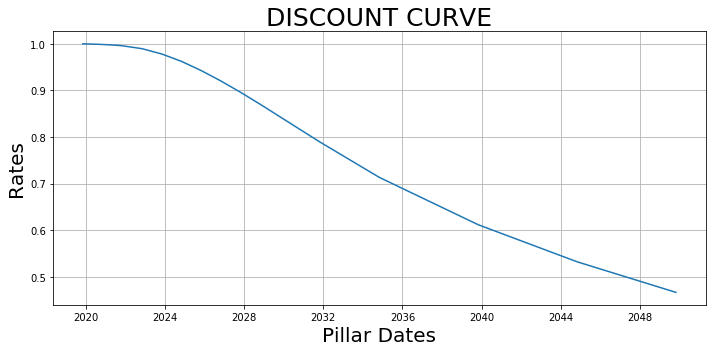

In [60]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(pillar_dates, x)
ax.set_xlabel('Pillar Dates', fontsize=20)
ax.set_ylabel('Rates', fontsize=20)
ax.set_title(r'DISCOUNT CURVE', fontsize=25)
plt.grid(True)
fig.tight_layout()
plt.show()

In [61]:
from finmarkets import CreditCurve
survival_probabilities['date'] = pd.to_datetime(survival_probabilities.date, format='%Y-%m-%d')
survival_dates  = [today] + survival_probabilities['date'].dt.date.tolist()
ndps = [1]
for i in range(len(survival_probabilities)):
    ndps.append(survival_probabilities['ndp'].tolist()[i])

cc = CreditCurve(survival_dates, ndps)

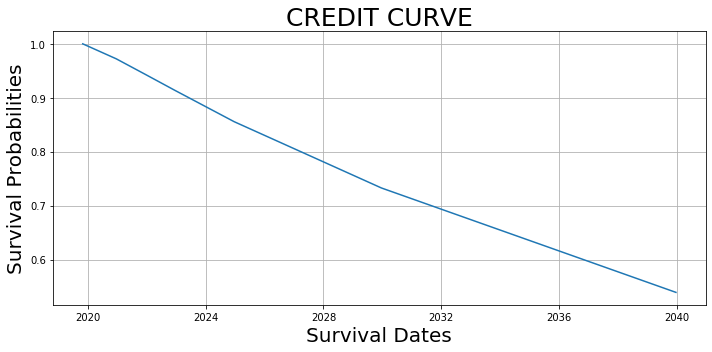

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(survival_dates, ndps)
ax.set_xlabel('Survival Dates', fontsize=20)
ax.set_ylabel('Survival Probabilities', fontsize=20)
ax.set_title(r'CREDIT CURVE', fontsize=25)
plt.grid(True)
fig.tight_layout()
plt.show()

In [63]:
from finmarkets import ForwardRateCurve
euribor6M_proj7['dates'] = pd.to_datetime(euribor6M_proj7.dates, format='%Y-%m-%d')
fr = ForwardRateCurve(euribor6M_proj7['dates'].dt.date.tolist(),
                     euribor6M_proj7['rates'].tolist())

In [64]:
from finmarkets import InterestRateSwap
irs_dummy = InterestRateSwap(today, nominal, 10, libor_tenor, 5)
fixed_rate = irs_dummy.swap_rate(dc, fr)
print (fixed_rate)

0.008723004430927505


In [65]:
irs = InterestRateSwap(today, nominal, fixed_rate, libor_tenor, 5)
irs.npv(dc, fr)

0.0

In [66]:
print (irs.fixed_leg_dates)

[datetime.date(2019, 10, 31), datetime.date(2020, 10, 31), datetime.date(2021, 10, 31), datetime.date(2022, 10, 31), datetime.date(2023, 10, 31), datetime.date(2024, 10, 31)]


In [67]:
import math, numpy
numpy.random.seed(1)
T = 5

sigma_daily = sigma/math.sqrt(365)
n_scenarios = 100

cvas = []
npvs = []
aS = []
apath = []
for i_scenario in range(n_scenarios):
    cva = 0
    S = irs.swap_rate(dc, fr)
    temp = []
    for d in range(0, 365*T): 
        A = irs.annuity(dc, today+relativedelta(days=d))
        S = S * math.exp(-0.5 * sigma_daily * sigma_daily + sigma_daily * numpy.random.normal())
        swap_npv = irs.notional * (S - irs.fixed_rate) * A
        temp.append(max(0, swap_npv))
        cva += (max(0, swap_npv)) * (cc.ndp(today+relativedelta(days=d)) - cc.ndp(today+relativedelta(days=d+1)))
    apath.append(temp)
    cvas.append(cva*(1-recovery))
    npvs.append((max(0, swap_npv)))
    
    
print ("CVA: {: 2f}".format(numpy.mean(cvas)))

CVA:  49723.272423


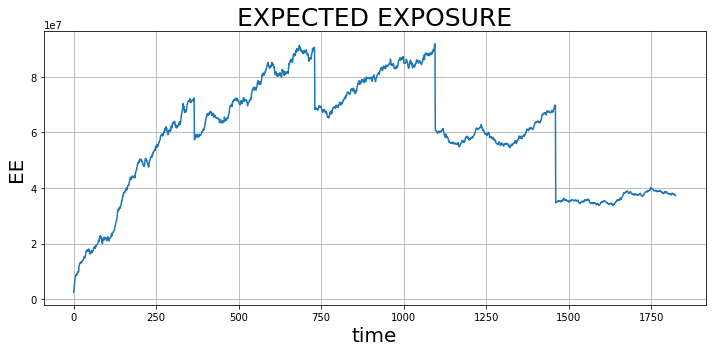

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(range(365*T), np.sum(np.array(apath), axis=0))
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('EE', fontsize=20)
ax.set_title(r'EXPECTED EXPOSURE', fontsize=25)
plt.grid(True)
fig.tight_layout()
plt.show()